# PW2_Network_Design
Classes: Stochastic Optimization \
Authors: Niclas Bourriez, Arthur Nardone and Jules Giraud

In [2]:
# Import of the pyomo module
from pyomo.kernel import Binary
from pyomo.environ import *
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Creation of a Concret Model
model = ConcreteModel()

In [3]:
# Defining the graph
nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
edges = [(1, 2), (1, 7), (2, 3), (2, 5),
         (2, 7), (2, 12), (3, 4), (3, 10),
         (4, 5), (4, 6), (5, 8), (5, 10),
         (5, 11), (6, 11), (7, 12), (8, 9),
         (8, 13), (9, 10), (10, 11), (12, 13), (1, 13), (2,8)]
costs = {
    (1,2) : 1.8,
    (1, 7) : 1,
    (2, 3) : 1.7,
    (2, 5) : 7,
    (2, 7) : 2,
    (2, 12) : 3,
    (3, 4) : 2,
    (3, 10) : 6.5,
    (4, 5) : 1,
    (4, 6) : 2,
    (5, 8) : 5,
    (5, 10) : 1,
    (5, 11) : 1.5,
    (6, 11) : 2.1,
    (7, 12) : 2,
    (8, 9) : 2,
    (8, 13) : 0.7,
    (9, 10) : 1.1,
    (10,11) : 1,
    (12, 13) : 2.5,
    (1, 13) : 5.4,
    (2, 8) : 2.3,
}

In [4]:
## Define sets ##
model.N = Set(initialize = range(1,14), doc='Nodes set')
model.k = Set(initialize = range(1,4), doc='Subnetwork number')
model.E = Set(initialize = edges, doc='Edges set')

#model.edges = Set(within = model.nodes*model.nodes, initialize=edges, doc='Edges')
#model.edges = Set(initialize=edges, doc='Edges')
#model.netName = Set(initialize = ['Orange', 'Sfr', 'Bouygues'], doc='Networks name')

In [5]:
## Define the parameters ##
model.cost = Param(initialize = 250, doc='Transforming an existing link into a backbone link costs 25 €/km')
model.K = Param(initialize = 3, doc='Number of subnetworks')
model.m = Param(initialize = 2, doc='Minimum cardinality pd subnetworks')
model.distance = Param(model.E, initialize=costs, doc='Distance between link SET')

In [6]:
## Define the variables
model.x = Var(model.N, model.k, domain=Binary)
model.w = Var(model.N, model.k, model.N, model.k, domain=Binary)

In [7]:
## Objective function

## Quadratic objective function

# def minimize_cost(model):
    # return sum(model.cost * model.distance[i, j] * model.x[i, h] *  model.x[j,k] for (i, j) in model.E for k in model.k for h in model.k if h != k)
# 
# model.obj = Objective(sense=minimize, rule=minimize_cost)

## MIP objective function

def minimize_cost(model):
    return sum(model.cost * model.distance[i, j] *  model.w[i,k, j,h] for (i, j) in model.E for k in model.k for h in model.k if h != k)

model.obj = Objective(sense=minimize, rule=minimize_cost)

In [8]:
## Define the constraints

# Subnetwork assignment: one node can only by assigned to ONLY one subnetwork
def subnetwork_assignment(model,i):
  return sum(model.x[i,k] for k in model.k) == 1
model.subnetwork_assignment = Constraint(model.N, rule=subnetwork_assignment, doc='Subnetwork assignment')

# Cardinality of subnetwork: minimum number of nodes in subnetwork
def subnetwork_card(model,k):
  return sum(model.x[i,k] for i in model.N) >=  model.m
model.subnetwork_card = Constraint(model.k, rule=subnetwork_card, doc='Cardinality of subnetwork')

# C1
def quad1(model,i,h,j,k):
  return model.w[i,k, j,h]  >=  model.x[i,h]+model.x[j,k]-1
model.quad1 = Constraint(model.N, model.k, model.N, model.k, rule=quad1, doc='quad 1')

# C2
def quad2(model,i,h,k):
  return model.w[i,k, j,h] <=  model.x[i,h]
model.quad2 = Constraint(model.N, model.k, model.N, model.k, rule=quad1, doc='quad 2')

# C3
def quad3(model,j,k,h):
  return model.w[i,k, j,h] <=  model.x[j,k]
model.quad3 = Constraint(model.N, model.k, model.N, model.k, rule=quad1, doc='quad 3')

In [9]:
## Display of the output ##

def pyomo_postprocess(options=None, instance=None, results=None):
  model.x.display()
  
# This emulates what the pyomo command-line tools does
from pyomo.opt import SolverFactory

opt = SolverFactory("gurobi",solver_io="python")
results = opt.solve(model, tee=True)
#sends results to stdout
results.write()
print("\nDisplaying Solution\n" + '-'*60)
pyomo_postprocess(None, model, results)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4579 rows, 1560 columns and 13650 nonzeros
Model fingerprint: 0x35fffea4
Variable types: 0 continuous, 1560 integer (1560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 9725.0000000
Presolve removed 4431 rows and 1389 columns
Presolve time: 0.01s
Presolved: 148 rows, 171 columns, 474 nonzeros
Variable types: 0 continuous, 171 integer (171 binary)

Root relaxation: objective 0.000000e+00, 52 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   31 9725.00000    0.00000   100%     -    0s
H    0     0    

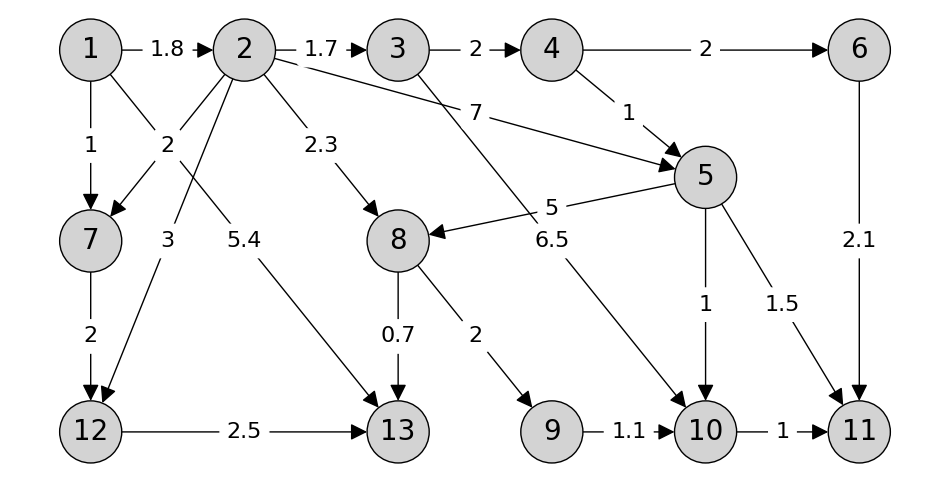

In [18]:
## graph modeling

graph = nx.DiGraph()
graph.add_nodes_from(list(nodes))
graph.add_edges_from(list(edges))

pos = ({1: (0, 6),
        2: (2, 6),
        3: (4, 6),
        4: (6, 6),
        5: (8, 4),
        6: (10, 6),
        7: (0, 3),
        8: (4, 3),
        9: (6, 0),
        10: (8,0),
        11: (10,0),
        12: (0,0),
        13: (4,0)})

node_colors = ['lightgray'
               for i in graph.nodes()]
edge_colors = ['black'
               for (i, j) in graph.edges()]
edge_widths = [1 for (i, j) in graph.edges()]
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors,
                       edgecolors='black', node_size=2000)
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(zip(nodes, nodes)),
                        font_size=20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize=25,
                       edge_color=edge_colors, width=edge_widths)
nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=costs,
                             font_size=16, rotate=False)
plt.axis('off')
plt.show()

    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/bb/cx79sznn6kj2ql4l68p0bjxc0000gn/T/tmp7h621atk.glpk.raw
 --wglp /var/folders/bb/cx79sznn6kj2ql4l68p0bjxc0000gn/T/tmp4fg8kjd7.glpk.glp
 --cpxlp /var/folders/bb/cx79sznn6kj2ql4l68p0bjxc0000gn/T/tmptb889gmi.pyomo.lp
Reading problem data from '/var/folders/bb/cx79sznn6kj2ql4l68p0bjxc0000gn/T/tmptb889gmi.pyomo.lp'...
11 rows, 21 columns, 41 non-zeros
121 lines were read
Writing problem data to '/var/folders/bb/cx79sznn6kj2ql4l68p0bjxc0000gn/T/tmp4fg8kjd7.glpk.glp'...
118 lines were written
GLPK Simplex Optimizer 5.0
11 rows, 21 columns, 41 non-zeros
Preprocessing...
10 rows, 20 columns, 40 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 9
      0: obj =   1.100000000e+0

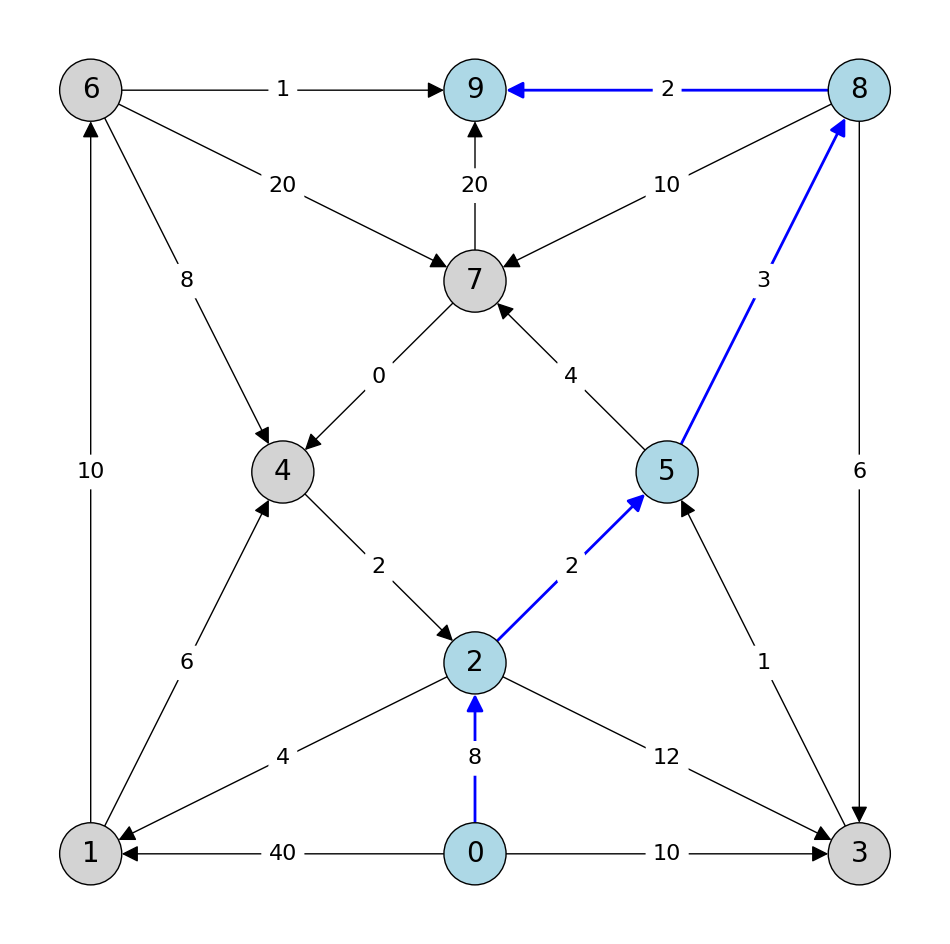

In [ ]:
## online example
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.DiGraph()
graph.add_nodes_from(list(nodes))
graph.add_edges_from(list(edges))

pos = ({0: (4, 0), 1: (0, 0), 2: (4, 2), 3: (8, 0), 4: (2, 4),
        5: (6, 4), 6: (0, 8), 7: (4, 6), 8: (8, 8), 9: (4, 8)})

nodes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
edges = {(0, 1), (0, 2), (0, 3), (1, 4),
         (1, 6), (2, 1), (2, 3), (2, 5),
         (3, 5), (4, 2), (5, 7), (5, 8),
         (6, 4), (6, 7), (6, 9), (7, 4),
         (7, 9), (8, 3), (8, 7), (8, 9)}
distance = {(0, 1): 40, (0, 2):  8, (0, 3): 10, (1, 4):  6,
            (1, 6): 10, (2, 1):  4, (2, 3): 12, (2, 5):  2,
            (3, 5):  1, (4, 2):  2, (5, 7):  4, (5, 8):  3,
            (6, 4):  8, (6, 7): 20, (6, 9):  1, (7, 4):  0,
            (7, 9): 20, (8, 3):  6, (8, 7): 10, (8, 9):  2}

Vm = defaultdict(set)
Vp = defaultdict(set)
for (i, j) in edges:
    Vm[i].add(j)
    Vp[j].add(i)
model = ConcreteModel()
model.nodes = Set(initialize=nodes)
model.edges = Set(within=model.nodes*model.nodes, initialize=edges)
model.Vm = Param(model.nodes, initialize=Vm, default=set(), within=Any)
model.Vp = Param(model.nodes, initialize=Vp, default=set(), within=Any)
model.s = 0
model.t = 9
model.distance = Param(model.edges, initialize=distance)
model.x = Var(model.edges, domain=Reals, bounds=(0, 1))
def shortest_path(model):
    return sum(model.distance[i, j] * model.x[i, j]
               for (i, j) in model.edges)

model.obj_shortest_path = Objective(sense=minimize, rule=shortest_path)
def flow_balance(model, i):
    flow_in = sum([model.x[j, i] for j in model.Vp[i]])
    flow_out = sum([model.x[i, j] for j in model.Vm[i]])
    if i == model.s:
        constraint = (flow_out == 1)
    elif i == model.t:
        constraint = (flow_in == 1)
    else:
        constraint = (flow_in == flow_out)
    return constraint

model.con_flow_balance = Constraint(model.nodes, rule=flow_balance)
solver = SolverFactory('glpk')
result = solver.solve(model, tee=True)
i = int(model.s)
path_nodes = [i]
path_edges = []
stop = False
while not stop:
    for j in model.Vm[i]:
        if model.x[i, j].value == 1:
            if j == int(model.t):
                stop = True
            path_nodes.append(j)
            path_edges.append((i, j))
            i = j
            break


node_colors = ['lightblue' if i in path_nodes else 'lightgray'
               for i in graph.nodes()]
edge_colors = ['blue' if (i, j) in path_edges else 'black'
               for (i, j) in graph.edges()]
edge_widths = [2 if (i, j) in path_edges else 1
               for (i, j) in graph.edges()]
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors,
                       edgecolors='black', node_size=2000)
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(zip(nodes, nodes)),
                        font_size=20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize=25,
                       edge_color=edge_colors, width=edge_widths)
nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=distance,
                             font_size=16, rotate=False)
plt.axis('off')
plt.show()